In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from tqdm import tqdm,tqdm_notebook
from prettytable import PrettyTable
import pickle
import os
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["axes.grid"] = False
from PIL import Image
import cv2
import tensorflow as tf
import multiprocessing
from multiprocessing.pool import ThreadPool
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
print('CWD is ',os.getcwd())

CWD is  /Users/patwit/Insync/polpinit@kku.ac.th/Google Drive/Files/Works/Advisee/Senior Projects/2563/detecting CMV/Detect-CMV-main


In [2]:
#dataset_path = os.listdir('fundus')
dataset_path = "Google Drive/My Drive/Files/Works/Advisee/Senior Projects/2563/detecting CMV/Detect-CMV-main/fundus"
#fundus_types = os.listdir('fundus')
fundus_types = "Google Drive/My Drive/Files/Works/Advisee/Senior Projects/2563/detecting CMV/Detect-CMV-main/fundus"
print(fundus_types)
print("types of fundus found: ", len(fundus_types))

Google Drive/My Drive/Files/Works/Advisee/Senior Projects/2563/detecting CMV/Detect-CMV-main/fundus
types of fundus found:  99


In [3]:
df_cmv= []
item = 'cmv'
cmv_fundus = os.listdir('fundus'+'/'+item)
for fundus in cmv_fundus:
    split_id = str(fundus).split('.')
    df_cmv.append((split_id[0],item,str('/'+item)+'/'+fundus,str(fundus)))
df_cmv = pd.DataFrame(data=df_cmv, columns=['id_code','diagnosis','file_path','filename'])
#df.to_csv(r'C:\Users\Yam\Desktop\real\cmv.csv', index = False, header=True)

In [4]:
df_nor= []
item = 'normal'
nor_fundus = os.listdir('fundus'+'/'+item)
for fundus in nor_fundus:
    split_id = str(fundus).split('.')
    df_nor.append((split_id[0],item,str('/'+item)+'/'+fundus,str(fundus)))
df_nor = pd.DataFrame(data=df_nor, columns=['id_code','diagnosis','file_path','filename'])

In [5]:
df_other= []
item = 'other'
other_fundus = os.listdir('fundus'+'/'+item)
for fundus in other_fundus:
    split_id = str(fundus).split('.')
    df_other.append((split_id[0],item,str('/'+item)+'/'+fundus,str(fundus)))
df_other = pd.DataFrame(data=df_other, columns=['id_code','diagnosis','file_path','filename'])

In [6]:
df_unk= []
item = 'unknown'
unk_fundus = os.listdir('fundus'+'/'+item)
for fundus in unk_fundus:
    split_id = str(fundus).split('.')
    df_unk.append((split_id[0],item,str('/'+item)+'/'+fundus,str(fundus)))
df_unk = pd.DataFrame(data=df_unk, columns=['id_code','diagnosis','file_path','filename'])

### Image Pre Processing

In [7]:
#image confict size
IMG_SIZE_X  = 270
IMG_SIZE_Y  = 200
IMG_SIZE = 512

In [8]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0):
            return img
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

def circle_crop(img, sigmaX = 50):     
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img

In [9]:
def cmv_image_save(file):
    input_filepath = os.path.join('./','fundus/cmv','{}.jpg'.format(file))
    output_filepath = os.path.join('./','fundus_dataset/cmv','{}.jpg'.format(file))
    img = cv2.imread(input_filepath)
    img = cv2.resize(img, (IMG_SIZE_X,IMG_SIZE_Y))
    #plt.imshow(img)
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))
    
def multiprocess_cmv_image_downloader(process:int, imgs:list):
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(cmv_image_save, imgs)
    results = len(results)
    return results

multiprocess_cmv_image_downloader(6, list(df_cmv.id_code.values))

MESSAGE: Running 6 process


32

MESSAGE: Running 6 process


Done: <matplotlib.backends.backend_agg.RendererAgg object at 0x7f9a899eb220>

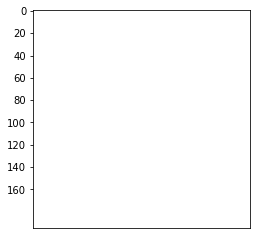

<Figure size 256.75x252.233 with 1 Axes>

RuntimeError: functools.partial(<bound method FigureCanvasAgg.print_png of <matplotlib.backends.backend_agg.FigureCanvasAgg object at 0x7f9a88d0f280>>, orientation='portrait') did not call Figure.draw, so no renderer is available

<Figure size 256.75x252.233 with 1 Axes>

Done: <matplotlib.backends.backend_agg.RendererAgg object at 0x7f9a899eb220>

<Figure size 256.75x252.233 with 1 Axes>

RuntimeError: functools.partial(<bound method FigureCanvasAgg.print_png of <matplotlib.backends.backend_agg.FigureCanvasAgg object at 0x7f9a88d0f280>>, orientation='portrait') did not call Figure.draw, so no renderer is available

<Figure size 256.75x252.233 with 1 Axes>

In [ ]:
def nor_image_save(file):
    input_filepath = os.path.join('./','fundus/normal','{}.jpg'.format(file))
    output_filepath = os.path.join('./','fundus_dataset/normal','{}.jpg'.format(file))
    img = cv2.imread(input_filepath)
    img = cv2.resize(img, (IMG_SIZE_X,IMG_SIZE_Y))
    img = circle_crop(img)
    imgplot = plt.imshow(img)
    plt.show()
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))
    
def multiprocess_nor_image_downloader(process:int, imgs:list):
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(nor_image_save, imgs)
    results = len(results)
    return results

multiprocess_nor_image_downloader(6, list(df_nor.id_code.values))

In [ ]:
def other_image_save(file):
    input_filepath = os.path.join('./','fundus/other','{}.jpg'.format(file))
    output_filepath = os.path.join('./','fundus_dataset/other','{}.jpg'.format(file))
    img = cv2.imread(input_filepath)
    img = cv2.resize(img, (IMG_SIZE_X,IMG_SIZE_Y))
    img = circle_crop(img) 
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))
    
def multiprocess_other_image_downloader(process:int, imgs:list):
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(other_image_save, imgs)
    results = len(results)
    return results

multiprocess_other_image_downloader(6, list(df_other.id_code.values))

In [ ]:
def unk_image_save(file):
    input_filepath = os.path.join('./','fundus/unknown','{}.jpg'.format(file))
    output_filepath = os.path.join('./','fundus_dataset/unknown','{}.jpg'.format(file))
    img = cv2.imread(input_filepath)
    img = cv2.resize(img, (IMG_SIZE_X,IMG_SIZE_Y))
    img = circle_crop(img) 
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))
    
def multiprocess_unk_image_downloader(process:int, imgs:list):
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(unk_image_save, imgs)
    results = len(results)
    return results

multiprocess_unk_image_downloader(6, list(df_unk.id_code.values))

### Augmentation image

In [ ]:
def generate_augmentations(lim):
    datagen = ImageDataGenerator(featurewise_center=True,
                                 featurewise_std_normalization=True,
                                 rotation_range=90,
                                 horizontal_flip=True)
    
    all_funduses = os.listdir('fundus_dataset'+'/'+'other')
    for fundus in all_funduses:
        img = cv2.imread(str('fundus_dataset'+'/'+'other')+'/'+fundus)
        img_arr = img.reshape((1,) + img.shape)
        i = 0
        for img_iterator in datagen.flow(x = img_arr,batch_size = 1,
                                         save_to_dir='fundus_dataset/other',
                                         save_prefix='aug_oth',
                                         save_format='jpg'):
            i += 1
            if i > lim:
                break
            plt.imshow((img_iterator.reshape(img_arr[0].shape)).astype(np.uint8))
            plt.title('Image augmentation ' + str(i))
            plt.show() 

In [ ]:
generate_augmentations(4)

In [ ]:
datagen = ImageDataGenerator(featurewise_center=True,
                            featurewise_std_normalization=True,
                            rotation_range=20,
                            horizontal_flip=True)

all_funduses = os.listdir('fundus_dataset'+'/'+'cmv')
for fundus in all_funduses:
    
    img = cv2.imread(str('fundus_dataset'+'/'+'cmv')+'/'+fundus)

    img_arr = img.reshape((1,) + img.shape)
    
    i = 0
    for img_iterator in datagen.flow(x = img_arr,batch_size = 1,
                                save_to_dir='fundus_dataset/cmv',
                                save_prefix='aug_cmv',
                                save_format='jpg'):
        i += 1
        if i > 3:
            break

In [ ]:
datagen = ImageDataGenerator(featurewise_center=True,
                            featurewise_std_normalization=True,
                            rotation_range=10,
                            horizontal_flip=True)

unk_path = os.listdir('fundus_dataset'+'/'+'unknown')
for fundus in unk_path:
    img = cv2.imread(str('fundus_dataset'+'/'+'unknown')+'/'+fundus)
    img_arr = img.reshape((1,) + img.shape)
    i = 0
    for img_iterator in datagen.flow(x = img_arr,batch_size = 1,
                                save_to_dir='fundus_dataset/unknown',
                                save_prefix='aug_unk',
                                save_format='jpg'):
        i += 1
        if i > 1:
            break

In [ ]:
datagen = ImageDataGenerator(featurewise_center=True,
                            featurewise_std_normalization=True,
                            rotation_range=20,
                            horizontal_flip=True)

unk_path = os.listdir('fundus_dataset'+'/'+'other')
for fundus in unk_path:
    img = cv2.imread(str('fundus_dataset'+'/'+'other')+'/'+fundus)
    img_arr = img.reshape((1,) + img.shape)
    i = 0
    for img_iterator in datagen.flow(x = img_arr,batch_size = 1,
                                save_to_dir='fundus_dataset/other',
                                save_prefix='aug_other',
                                save_format='jpg'):
        i += 1
        if i > 6:
            break

In [ ]:
n_normal = os.listdir('fundus_dataset/normal')
n_cmv = os.listdir('fundus_dataset/cmv')
n_other = os.listdir('fundus_dataset/other')
n_unknown = os.listdir('fundus_dataset/unknown')
print("Total normal funduses: ", len(n_normal))
print("Total CMV retinitis funduses: ", len(n_cmv))
print("Total Other retinitis funduses: ", len(n_other))
print("Total unknown funduses: ", len(n_unknown))

In [ ]:
df_fundus = pd.read_csv('fundus.csv')
df_group = pd.DataFrame(df_fundus.groupby('diagnosis').agg('size').reset_index())
df_group.columns = ['diagnosis','count']
sns.set(rc={'figure.figsize':(10,5)}, style = 'whitegrid')
sns.barplot(x = 'diagnosis',y='count',data = df_group,palette = "PRGn_r")
plt.title('Output Class Distribution Before Augmentation')
plt.show() 

In [ ]:
df_aug_fundus= []
for item in fundus_types:
    all_fundus = os.listdir('fundus_dataset'+'/'+item)
    for fundus in all_fundus:
        df_aug_fundus.append((item,str('fundus_dataset'+'/'+item)+'/'+fundus))
df_aug_file = pd.DataFrame(data=df_aug_fundus, columns=['diagnosis','file_path'])
df_group = pd.DataFrame(df_aug_file.groupby('diagnosis').agg('size').reset_index())
df_group.columns = ['diagnosis','count']
sns.set(rc={'figure.figsize':(10,5)}, style = 'whitegrid')
sns.barplot(x = 'diagnosis',y='count',data = df_group,palette = "coolwarm")
plt.title('Output Class Distribution After Augmentation')
plt.show() 